In [1]:
import pandas as pd
import os
import glob
from statsmodels.stats.multitest import fdrcorrection
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib.lines import Line2D
import random
import matplotlib.patches as patches

### Volcano plot

In [2]:
dfintra002_05 = pd.read_csv("data/k1000_00205_check_18364muta.csv",sep="\t")
dfintra002_05["log_odds_ratio"] =  dfintra002_05.apply(lambda row: np.log2(row["odds_ratio"]+0.01),axis=1)

dfintra001_002 = pd.read_csv("data/k1000_001002_check_14144muta.csv",sep="\t")
dfintra001_002["log_odds_ratio"] =  dfintra001_002.apply(lambda row: np.log2(row["odds_ratio"]+0.01),axis=1)

dfintra002_005 = pd.read_csv("data/k1000_002005_check_9617muta.csv",sep="\t")
dfintra002_005["log_odds_ratio"] =  dfintra002_005.apply(lambda row: np.log2(row["odds_ratio"]+0.01),axis=1)

dfintra01_05 = pd.read_csv("data/k1000_0105_check_3947muta.csv",sep="\t")
dfintra01_05["log_odds_ratio"] =  dfintra002_005.apply(lambda row: np.log2(row["odds_ratio"]+0.01),axis=1)


### Distribution

In [3]:
df_annotations = pd.read_csv("../../data/covid_19_with16_extra_genes.gff",sep="\t",comment="#",names=["chr_","Source","region","start","end","smth","strand","coding","annotation"])

import re
def look_gene_name(name):
    m = re.search("gene=([A-Za-z0-9]+)",name)
    gene = m.group(0)
    return m[0].split("=")[1]
df_annotations = df_annotations[df_annotations["region"]=="gene"]
df_annotations["gene"] = df_annotations.apply(lambda row: look_gene_name(row["annotation"]),axis=1)
df_annotations_orf1ab = pd.DataFrame([["NC_045512v2","RefSeq","gene",266,21555,".","+","orf1ab","orf1a"]],columns=["chr_","Source","region","start","end","smth","strand","gene","annotation"])

In [4]:
df_annotations_total = pd.concat([df_annotations[~df_annotations["gene"].str.contains("nsp")],df_annotations_orf1ab])

In [5]:
df_annotations_total.head()

,chr_,Source,region,start,end,smth,strand,coding,annotation,gene
69,NC_045512v2,RefSeq,gene,21563,25384,.,+,.,ID=gene-GU280_gp02;Name=S;Dbxref=GeneID:437405...,S
73,NC_045512v2,RefSeq,gene,25393,26220,.,+,.,ID=gene-GU280_gp03;Name=ORF3a;Dbxref=GeneID:43...,ORF3a
77,NC_045512v2,RefSeq,gene,26245,26472,.,+,.,ID=gene-GU280_gp04;Name=E;Dbxref=GeneID:437405...,E
81,NC_045512v2,RefSeq,gene,26523,27191,.,+,.,ID=gene-GU280_gp05;Name=M;Dbxref=GeneID:437405...,M
85,NC_045512v2,RefSeq,gene,27202,27387,.,+,.,ID=gene-GU280_gp06;Name=ORF6;Dbxref=GeneID:437...,ORF6


In [6]:
d={"LUSC": "#e6194b", "ACC": "#3cb44b", "KICH": "#ffe119", "DLBC": "#4363d8", "CHOL": "#d8b365", "CESC": "#911eb4", "BLCA": "#46f0f0", "BRCA": "#f032e6", "ESCA": "#bcf60c", "KIRC": "#fabebe", "GBM": "#008080", "COADREAD": "#e6beff", "HNSC": "#9a6324", "TGCT": "#fffac8", "THYM": "#800000", "THCA": "#aaffc3", "LIHC": "#808000", "LGG": "#addd8e", "UCS": "#ffd8b1", "PAAD": "#000075", "SARC": "#808080", "MESO": "#ffffff", "STAD": "#fc8520", "UCEC": "#fa9fb5", "PCPG": "#336633", "LAML": "#7fcdbb", "PRAD": "#edf8b1", "SKCM": "#2c7fb8", "PAN": "#dd1c77", "KIRP": "#bdbdbd", "UVM": "#1c9099", "LUAD": "#fbe7ce", "OV": "#ffffbf"}
colors=["grey"]+list(d.values())

### 

/home/mgrau/apps/miniconda3/envs/njupy/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/mgrau/apps/miniconda3/envs/njupy/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


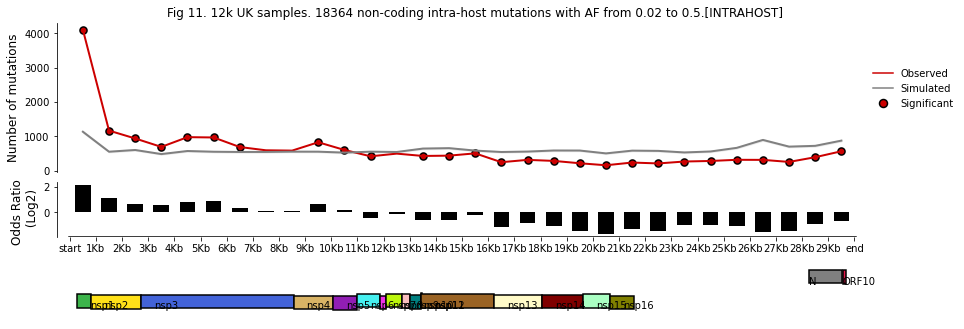

In [18]:
fig, ax = plt.subplots(figsize=(15, 5.5))
gs = gridspec.GridSpec(figure=fig, ncols=1, nrows=5,  height_ratios=[22, 8, 4, 2, 2])
gs.update(hspace=0.2, wspace=0.00)
ax0 = plt.subplot(gs[0]) # expected vs observed
ax1 = plt.subplot(gs[1]) # odds ratio
ax_ = plt.subplot(gs[2], sharex=ax0) # empy
ax2 = plt.subplot(gs[3], sharex=ax0) # genes-draw
ax3 = plt.subplot(gs[4], sharex=ax0) # genes-draw

x=dfintra002_05["id_chunk"].values
y1=dfintra002_05["n_observed"].values
y2=dfintra002_05["mean_simulated"].values
df_sig = dfintra002_05[dfintra002_05["pvalue"]<0.01]
# Observed
ax0.plot(y1,color="#cc0000",lw=2)
x_sig = df_sig["id_chunk"].values
y_sig = df_sig["n_observed"].values
ax0.scatter(x=x_sig,y=y_sig,color="#cc0000",s=50,lw=1.5,edgecolor="black")
ax0.set_ylabel("Number of mutations",fontsize=12)
# Simulated
ax0.plot(y2,color="grey",lw=2.)
# Confidence internals
y_low =[y2[i] - v for i,v in enumerate(dfintra002_05["stdev"].values)]
y_high =[y2[i] + v for i,v in enumerate(dfintra002_05["stdev"].values)]
ax0.fill_between(x,y_low,y_high,color="grey",alpha=0.1)
# barplots oddsratio
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_ylabel("Odds Ratio \n (Log2)",fontsize=12)
ax1.bar(x=x,height=dfintra002_05["log_odds_ratio"].values,color="black",width=0.6)

j=0
for i,r in df_annotations_total.sort_values("start").iterrows():
    rect = patches.Rectangle(xy=(r["start"]/1000-.5,ax2.get_ylim()[1]+random.uniform(-0.1,0.1)),width=(r["end"]-r["start"]+1)/1000,height=1,linewidth=1.5,facecolor=colors[j], clip_on=False, edgecolor="black")
    ax2.add_patch(rect)
    ax2.annotate(xy=(r["start"]/1000-.5,ax2.get_ylim()[1]),s=r["gene"])
    j+=1
    

for i,r in df_annotations[df_annotations["gene"].str.contains("nsp")].iterrows():
    rect = patches.Rectangle(xy=(r["start"]/1000-0.5,ax2.get_ylim()[1]+random.uniform(-0.1,0.1)),width=(r["end"]-r["start"]+1)/1000,height=1,linewidth=1.5,facecolor=colors[j], clip_on=False, edgecolor="black")
    ax3.add_patch(rect)
    ax3.annotate(xy=(r["start"]/1000,ax2.get_ylim()[1]),s=r["gene"])
    j+=1
    
_=ax1.set_xticks([v-0.5 for v in x]+[x[-1]+0.5])
_=ax1.set_xticklabels(["start"]+[str(v)+"Kb" for v in x[1:]]+["end"])
max_odd = np.nanmax(dfintra002_05["odds_ratio"].values) + 0.1
#ax1.set_ylim(-max_odd,max_odd)
ax2.set_xlabel("chunk number")
ax2.set_ylabel("number of mutations")
legend_elements = [Line2D([0], [0],  color='#cc0000', label='Observed',
                          markerfacecolor="#cc0000", markersize=10),
                   Line2D([0], [0],  color='grey', label='Simulated',
                          markerfacecolor='grey', markersize=10),
                  Line2D([0], [0],  color='white', label='Significant', markeredgewidth=1.5, markeredgecolor="black",
                          markerfacecolor='#cc0000', markersize=8, marker="o")]

# Create the figure
ax0.legend(handles=legend_elements, loc=(0.97,0.4),frameon=False)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

ax2.axis('off')
ax_.axis('off')
ax3.axis('off')
ax1.set_xlim(-1,31)
ax1.axhline(ax1.get_ylim()[0],xmin=0.015,xmax=0.955,lw=1.5,color="black")
ax2.set_xlim(-1,31)
ax3.set_xlim(-1,31)
ax0.set_xlim(-1,31)
ax0.set_xticks([])
ax0.set_title("Fig 11. 12k UK samples. 18364 non-coding intra-host mutations with AF from 0.02 to 0.5.[INTRAHOST]")
plt.savefig("./img/mutrate_intra00205.png")
plt.show()


/home/mgrau/apps/miniconda3/envs/njupy/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/mgrau/apps/miniconda3/envs/njupy/lib/python3.7/site-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


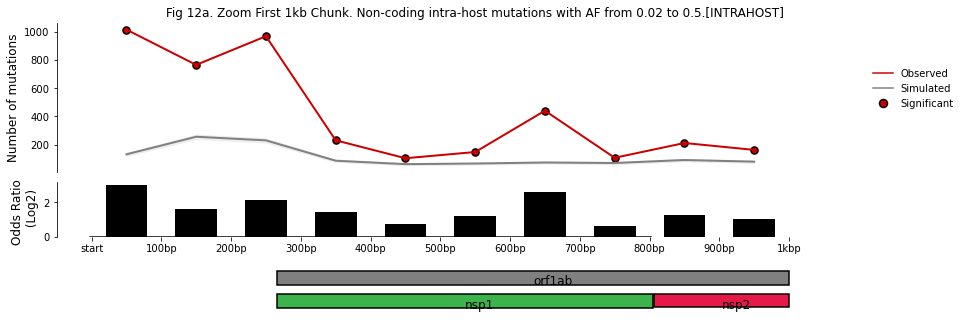

In [19]:
df = pd.read_csv("data/k100_00205_check5utr.csv",sep="\t")

df["log_odds_ratio"] =  df.apply(lambda row: np.log2(row["odds_ratio"]+0.01),axis=1)
#df_annotations = pd.read_csv("../../data/covid_19_with16_extra_genes.gff",sep="\t",comment="#",names=["chr_","Source","region","start","end","smth","strand","coding","annotation"])
df_annotations = df_annotations[df_annotations["region"]=="gene"]
df_annotations["gene"] = df_annotations.apply(lambda row: look_gene_name(row["annotation"]),axis=1)
df_annotations_orf1ab = pd.DataFrame([["NC_045512v2","RefSeq","gene",266,21555,".","+","orf1ab","orf1a"]],columns=["chr_","Source","region","start","end","smth","strand","gene","annotation"])
df_annotations_total = pd.concat([df_annotations[~df_annotations["gene"].str.contains("nsp")],df_annotations_orf1ab])
df_annotations_total = df_annotations_total[df_annotations_total["start"]<1000]
d={"LUSC": "#e6194b", "ACC": "#3cb44b", "KICH": "#ffe119", "DLBC": "#4363d8", "CHOL": "#d8b365", "CESC": "#911eb4", "BLCA": "#46f0f0", "BRCA": "#f032e6", "ESCA": "#bcf60c", "KIRC": "#fabebe", "GBM": "#008080", "COADREAD": "#e6beff", "HNSC": "#9a6324", "TGCT": "#fffac8", "THYM": "#800000", "THCA": "#aaffc3", "LIHC": "#808000", "LGG": "#addd8e", "UCS": "#ffd8b1", "PAAD": "#000075", "SARC": "#808080", "MESO": "#ffffff", "STAD": "#fc8520", "UCEC": "#fa9fb5", "PCPG": "#336633", "LAML": "#7fcdbb", "PRAD": "#edf8b1", "SKCM": "#2c7fb8", "PAN": "#dd1c77", "KIRP": "#bdbdbd", "UVM": "#1c9099", "LUAD": "#fbe7ce", "OV": "#ffffbf"}
colors=["grey"]+list(d.values())
fig, ax = plt.subplots(figsize=(15, 5.5))
gs = gridspec.GridSpec(figure=fig, ncols=1, nrows=5,  height_ratios=[22, 8, 4, 2, 2])
gs.update(hspace=0.2, wspace=0.00)
ax0 = plt.subplot(gs[0]) # expected vs observed
ax1 = plt.subplot(gs[1]) # odds ratio
ax_ = plt.subplot(gs[2], sharex=ax0) # empy
ax2 = plt.subplot(gs[3], sharex=ax0) # genes-draw
ax3 = plt.subplot(gs[4], sharex=ax0) # genes-draw

x=df["id_chunk"].values
y1=df["n_observed"].values
y2=df["mean_simulated"].values
df_sig = df[df["pvalue"]<0.01]
# Observed
ax0.plot(y1,color="#cc0000",lw=2)
x_sig = df_sig["id_chunk"].values
y_sig = df_sig["n_observed"].values
ax0.scatter(x=x_sig,y=y_sig,color="#cc0000",s=50,lw=1.5,edgecolor="black")
ax0.set_ylabel("Number of mutations",fontsize=12)
# Simulated
ax0.plot(y2,color="grey",lw=2.)
# Confidence internals
y_low =[y2[i] - v for i,v in enumerate(df["stdev"].values)]
y_high =[y2[i] + v for i,v in enumerate(df["stdev"].values)]
ax0.fill_between(x,y_low,y_high,color="grey",alpha=0.1)
# barplots oddsratio
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_ylabel("Odds Ratio \n (Log2)",fontsize=12)
ax1.bar(x=x,height=df["log_odds_ratio"].values,color="black",width=0.6)

   
_=ax1.set_xticks([v-0.5 for v in x]+[x[-1]+0.5])
_=ax1.set_xticklabels(["start"]+[str(v*100)+"bp" for v in x[1:]]+["1kbp"])
j=0
for i,r in df_annotations_total.sort_values("start",ascending=False).iterrows():
    end=np.nanmin([float(r["end"]),1000])
    start_rect = (r["start"]/100) -0.5
  
    w=((end - r["start"]) / 100)
    rect = patches.Rectangle(xy=(start_rect,ax2.get_ylim()[1]+random.uniform(-0.1,0.1)),width=w,height=1,linewidth=1.5,facecolor=colors[j], clip_on=False, edgecolor="black")
    ax2.add_patch(rect)
    ax2.annotate(xy=(start_rect+(w/2) ,ax2.get_ylim()[1]),s=r["gene"],fontsize=12)
    j+=1
    
for i,r in df_annotations[df_annotations["start"]<1000].sort_values("start",ascending=False).iterrows():
    end=np.nanmin([float(r["end"]),1000])
    start_rect = (r["start"]/100) -0.5
  
    w=((end - r["start"]) / 100)
    rect = patches.Rectangle(xy=(start_rect,ax2.get_ylim()[1]+random.uniform(-0.1,0.1)),width=w,height=1,linewidth=1.5,facecolor=colors[j], clip_on=False, edgecolor="black")
    ax3.add_patch(rect)
    ax3.annotate(xy=(start_rect+(w/2) ,ax2.get_ylim()[1]),s=r["gene"],fontsize=12)
    j+=1
    
    
max_odd = np.nanmax(df["odds_ratio"].values) + 0.1
ax2.set_xlabel("chunk number")
ax2.set_ylabel("number of mutations")
legend_elements = [Line2D([0], [0],  color='#cc0000', label='Observed',
                          markerfacecolor="#cc0000", markersize=10),
                   Line2D([0], [0],  color='grey', label='Simulated',
                          markerfacecolor='grey', markersize=10),
                  Line2D([0], [0],  color='white', label='Significant', markeredgewidth=1.5, markeredgecolor="black",
                          markerfacecolor='#cc0000', markersize=8, marker="o")]

# Create the figure
ax0.legend(handles=legend_elements, loc=(0.97,0.4),frameon=False)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

ax2.axis('off')
ax_.axis('off')
ax3.axis('off')
ax1.set_xlim(-1,11)
ax1.axhline(ax1.get_ylim()[0],xmin=0.04,xmax=0.71,lw=1.5,color="black")
ax2.set_xlim(-1,11)
ax3.set_xlim(-1,11)
ax0.set_xlim(-1,11)
ax0.set_xticks([])
ax0.set_title("Fig 12a. Zoom First 1kb Chunk. Non-coding intra-host mutations with AF from 0.02 to 0.5.[INTRAHOST]")
plt.savefig("./img/mutrate_intra5end_00205.png")
plt.show()


/home/mgrau/apps/miniconda3/envs/njupy/lib/python3.7/site-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


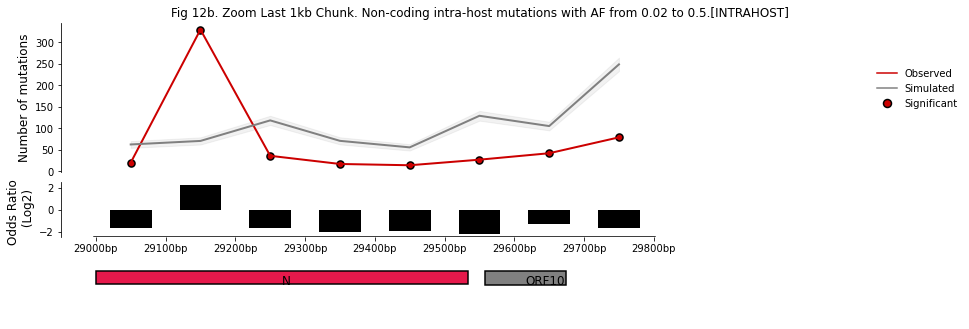

In [20]:
df = pd.read_csv("data/k100_00205_check3utr.csv",sep="\t")
df["log_odds_ratio"] =  df.apply(lambda row: np.log2(row["odds_ratio"]+0.01),axis=1)

#df_annotations = pd.read_csv("../../data/covid_19_with16_extra_genes.gff",sep="\t",comment="#",names=["chr_","Source","region","start","end","smth","strand","coding","annotation"])
df_annotations = df_annotations[df_annotations["region"]=="gene"]
df_annotations["gene"] = df_annotations.apply(lambda row: look_gene_name(row["annotation"]),axis=1)

df_annotations_total = pd.concat([df_annotations[~df_annotations["gene"].str.contains("nsp")]])
df_annotations_total = df_annotations_total[df_annotations_total["end"]>29000]

d={"LUSC": "#e6194b", "ACC": "#3cb44b", "KICH": "#ffe119", "DLBC": "#4363d8", "CHOL": "#d8b365", "CESC": "#911eb4", "BLCA": "#46f0f0", "BRCA": "#f032e6", "ESCA": "#bcf60c", "KIRC": "#fabebe", "GBM": "#008080", "COADREAD": "#e6beff", "HNSC": "#9a6324", "TGCT": "#fffac8", "THYM": "#800000", "THCA": "#aaffc3", "LIHC": "#808000", "LGG": "#addd8e", "UCS": "#ffd8b1", "PAAD": "#000075", "SARC": "#808080", "MESO": "#ffffff", "STAD": "#fc8520", "UCEC": "#fa9fb5", "PCPG": "#336633", "LAML": "#7fcdbb", "PRAD": "#edf8b1", "SKCM": "#2c7fb8", "PAN": "#dd1c77", "KIRP": "#bdbdbd", "UVM": "#1c9099", "LUAD": "#fbe7ce", "OV": "#ffffbf"}
colors=["grey"]+list(d.values())

fig, ax = plt.subplots(figsize=(15, 5.5))
gs = gridspec.GridSpec(figure=fig, ncols=1, nrows=5,  height_ratios=[22, 8, 4, 2, 2])
gs.update(hspace=0.2, wspace=0.00)
ax0 = plt.subplot(gs[0]) # expected vs observed
ax1 = plt.subplot(gs[1]) # odds ratio
ax_ = plt.subplot(gs[2], sharex=ax0) # empy
ax2 = plt.subplot(gs[3], sharex=ax0) # genes-draw
ax3 = plt.subplot(gs[4], sharex=ax0) # genes-draw

x=df["id_chunk"].values
y1=df["n_observed"].values
y2=df["mean_simulated"].values
df_sig = df[df["pvalue"]<0.01]
# Observed
ax0.plot(y1,color="#cc0000",lw=2)
x_sig = df_sig["id_chunk"].values
y_sig = df_sig["n_observed"].values
ax0.scatter(x=x_sig,y=y_sig,color="#cc0000",s=50,lw=1.5,edgecolor="black")
ax0.set_ylabel("Number of mutations",fontsize=12)
# Simulated
ax0.plot(y2,color="grey",lw=2.)
# Confidence internals
y_low =[y2[i] - v for i,v in enumerate(df["stdev"].values)]
y_high =[y2[i] + v for i,v in enumerate(df["stdev"].values)]
ax0.fill_between(x,y_low,y_high,color="grey",alpha=0.1)
# barplots oddsratio
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_ylabel("Odds Ratio \n (Log2)",fontsize=12)
ax1.bar(x=x,height=df["log_odds_ratio"].values,color="black",width=0.6)
    
_=ax1.set_xticks([v-0.5 for v in x]+[x[-1]+0.5])
_=ax1.set_xticklabels(["29000bp"]+["29"+str(v*100)+"bp" for v in x[1:]]+["29800bp"])
j=0
for i,r in df_annotations_total.sort_values("start",ascending=False).iterrows():
    start=np.nanmax([float(r["start"]),29000])
    start_rect = ((start-29000.0)/100) -0.5
    
    w=((r["end"] - start) / 100)
    rect = patches.Rectangle(xy=(start_rect,ax2.get_ylim()[1]+random.uniform(-0.1,0.1)),width=w,height=1,linewidth=1.5,facecolor=colors[j], clip_on=False, edgecolor="black")
    ax2.add_patch(rect)
    ax2.annotate(xy=(start_rect+(w/2) ,ax2.get_ylim()[1]),s=r["gene"],fontsize=12)
    j+=1
    
max_odd = np.nanmax(df["odds_ratio"].values) + 0.1
ax2.set_xlabel("chunk number")
ax2.set_ylabel("number of mutations")
legend_elements = [Line2D([0], [0],  color='#cc0000', label='Observed',
                          markerfacecolor="#cc0000", markersize=10),
                   Line2D([0], [0],  color='grey', label='Simulated',
                          markerfacecolor='grey', markersize=10),
                  Line2D([0], [0],  color='white', label='Significant', markeredgewidth=1.5, markeredgecolor="black",
                          markerfacecolor='#cc0000', markersize=8, marker="o")]

# Create the figure
ax0.legend(handles=legend_elements, loc=(0.97,0.4),frameon=False)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

ax2.axis('off')
ax_.axis('off')
ax3.axis('off')
ax1.set_xlim(-1,11)
ax1.axhline(ax1.get_ylim()[0],xmin=0.04,xmax=0.71,lw=1.5,color="black")
ax2.set_xlim(-1,11)
ax3.set_xlim(-1,11)
ax0.set_xlim(-1,11)
ax0.set_xticks([])
ax0.set_title("Fig 12b. Zoom Last 1kb Chunk. Non-coding intra-host mutations with AF from 0.02 to 0.5.[INTRAHOST]")
plt.savefig("./img/mutrate_intra3end_00205.png")
plt.show()


/home/mgrau/apps/miniconda3/envs/njupy/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/mgrau/apps/miniconda3/envs/njupy/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


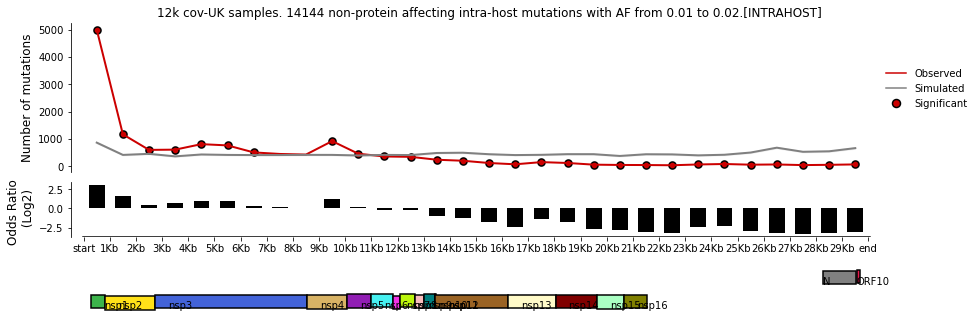

In [21]:
fig, ax = plt.subplots(figsize=(15, 5.5))
gs = gridspec.GridSpec(figure=fig, ncols=1, nrows=5,  height_ratios=[22, 8, 4, 2, 2])
gs.update(hspace=0.2, wspace=0.00)
ax0 = plt.subplot(gs[0]) # expected vs observed
ax1 = plt.subplot(gs[1]) # odds ratio
ax_ = plt.subplot(gs[2], sharex=ax0) # empy
ax2 = plt.subplot(gs[3], sharex=ax0) # genes-draw
ax3 = plt.subplot(gs[4], sharex=ax0) # genes-draw

x=dfintra001_002["id_chunk"].values
y1=dfintra001_002["n_observed"].values
y2=dfintra001_002["mean_simulated"].values
df_sig = dfintra001_002[dfintra001_002["pvalue"]<0.01]
# Observed
ax0.plot(y1,color="#cc0000",lw=2)
x_sig = df_sig["id_chunk"].values
y_sig = df_sig["n_observed"].values
ax0.scatter(x=x_sig,y=y_sig,color="#cc0000",s=50,lw=1.5,edgecolor="black")
ax0.set_ylabel("Number of mutations",fontsize=12)
# Simulated
ax0.plot(y2,color="grey",lw=2.)
# Confidence internals
y_low =[y2[i] - v for i,v in enumerate(dfintra001_002["stdev"].values)]
y_high =[y2[i] + v for i,v in enumerate(dfintra001_002["stdev"].values)]
ax0.fill_between(x,y_low,y_high,color="grey",alpha=0.1)
# barplots oddsratio
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_ylabel("Odds Ratio \n (Log2)",fontsize=12)
ax1.bar(x=x,height=dfintra001_002["log_odds_ratio"].values,color="black",width=0.6)

j=0
for i,r in df_annotations_total.sort_values("start").iterrows():
    rect = patches.Rectangle(xy=(r["start"]/1000-.5,ax2.get_ylim()[1]+random.uniform(-0.1,0.1)),width=(r["end"]-r["start"]+1)/1000,height=1,linewidth=1.5,facecolor=colors[j], clip_on=False, edgecolor="black")
    ax2.add_patch(rect)
    ax2.annotate(xy=(r["start"]/1000-.5,ax2.get_ylim()[1]),s=r["gene"])
    j+=1
    

for i,r in df_annotations[df_annotations["gene"].str.contains("nsp")].iterrows():
    rect = patches.Rectangle(xy=(r["start"]/1000-0.5,ax2.get_ylim()[1]+random.uniform(-0.1,0.1)),width=(r["end"]-r["start"]+1)/1000,height=1,linewidth=1.5,facecolor=colors[j], clip_on=False, edgecolor="black")
    ax3.add_patch(rect)
    ax3.annotate(xy=(r["start"]/1000,ax2.get_ylim()[1]),s=r["gene"])
    j+=1
    
_=ax1.set_xticks([v-0.5 for v in x]+[x[-1]+0.5])
_=ax1.set_xticklabels(["start"]+[str(v)+"Kb" for v in x[1:]]+["end"])
max_odd = np.nanmax(dfintra001_002["odds_ratio"].values) + 0.1
#ax1.set_ylim(-max_odd,max_odd)
ax2.set_xlabel("chunk number")
ax2.set_ylabel("number of mutations")
legend_elements = [Line2D([0], [0],  color='#cc0000', label='Observed',
                          markerfacecolor="#cc0000", markersize=10),
                   Line2D([0], [0],  color='grey', label='Simulated',
                          markerfacecolor='grey', markersize=10),
                  Line2D([0], [0],  color='white', label='Significant', markeredgewidth=1.5, markeredgecolor="black",
                          markerfacecolor='#cc0000', markersize=8, marker="o")]

# Create the figure
ax0.legend(handles=legend_elements, loc=(0.97,0.4),frameon=False)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

ax2.axis('off')
ax_.axis('off')
ax3.axis('off')
ax1.set_xlim(-1,31)
ax1.axhline(ax1.get_ylim()[0],xmin=0.015,xmax=0.955,lw=1.5,color="black")
ax2.set_xlim(-1,31)
ax3.set_xlim(-1,31)
ax0.set_xlim(-1,31)
ax0.set_xticks([])
ax0.set_title("Fig 13. 12k cov-UK samples. 14144 non-protein affecting intra-host mutations with AF from 0.01 to 0.02.[INTRAHOST]")
plt.savefig("./img/mutrate_intra001002.png")
plt.show()


/home/mgrau/apps/miniconda3/envs/njupy/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/mgrau/apps/miniconda3/envs/njupy/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


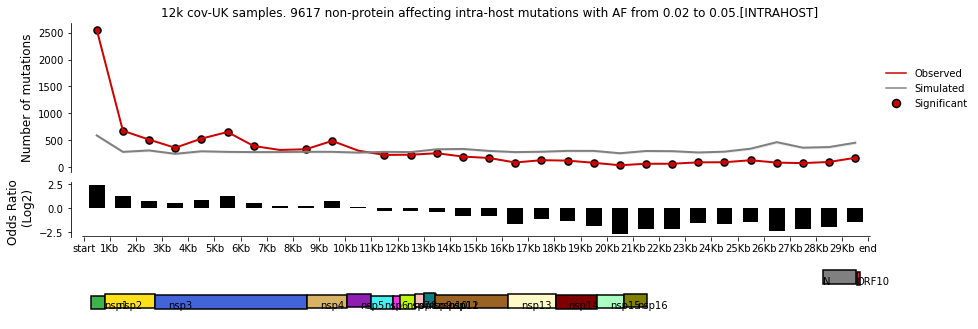

In [22]:
fig, ax = plt.subplots(figsize=(15, 5.5))
gs = gridspec.GridSpec(figure=fig, ncols=1, nrows=5,  height_ratios=[22, 8, 4, 2, 2])
gs.update(hspace=0.2, wspace=0.00)
ax0 = plt.subplot(gs[0]) # expected vs observed
ax1 = plt.subplot(gs[1]) # odds ratio
ax_ = plt.subplot(gs[2], sharex=ax0) # empy
ax2 = plt.subplot(gs[3], sharex=ax0) # genes-draw
ax3 = plt.subplot(gs[4], sharex=ax0) # genes-draw

x=dfintra002_005["id_chunk"].values
y1=dfintra002_005["n_observed"].values
y2=dfintra002_005["mean_simulated"].values
df_sig = dfintra002_005[dfintra002_005["pvalue"]<0.01]
# Observed
ax0.plot(y1,color="#cc0000",lw=2)
x_sig = df_sig["id_chunk"].values
y_sig = df_sig["n_observed"].values
ax0.scatter(x=x_sig,y=y_sig,color="#cc0000",s=50,lw=1.5,edgecolor="black")
ax0.set_ylabel("Number of mutations",fontsize=12)
# Simulated
ax0.plot(y2,color="grey",lw=2.)
# Confidence internals
y_low =[y2[i] - v for i,v in enumerate(dfintra002_005["stdev"].values)]
y_high =[y2[i] + v for i,v in enumerate(dfintra002_005["stdev"].values)]
ax0.fill_between(x,y_low,y_high,color="grey",alpha=0.1)
# barplots oddsratio
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_ylabel("Odds Ratio \n (Log2)",fontsize=12)
ax1.bar(x=x,height=dfintra002_005["log_odds_ratio"].values,color="black",width=0.6)

j=0
for i,r in df_annotations_total.sort_values("start").iterrows():
    rect = patches.Rectangle(xy=(r["start"]/1000-.5,ax2.get_ylim()[1]+random.uniform(-0.1,0.1)),width=(r["end"]-r["start"]+1)/1000,height=1,linewidth=1.5,facecolor=colors[j], clip_on=False, edgecolor="black")
    ax2.add_patch(rect)
    ax2.annotate(xy=(r["start"]/1000-.5,ax2.get_ylim()[1]),s=r["gene"])
    j+=1
    

for i,r in df_annotations[df_annotations["gene"].str.contains("nsp")].iterrows():
    rect = patches.Rectangle(xy=(r["start"]/1000-0.5,ax2.get_ylim()[1]+random.uniform(-0.1,0.1)),width=(r["end"]-r["start"]+1)/1000,height=1,linewidth=1.5,facecolor=colors[j], clip_on=False, edgecolor="black")
    ax3.add_patch(rect)
    ax3.annotate(xy=(r["start"]/1000,ax2.get_ylim()[1]),s=r["gene"])
    j+=1
    
_=ax1.set_xticks([v-0.5 for v in x]+[x[-1]+0.5])
_=ax1.set_xticklabels(["start"]+[str(v)+"Kb" for v in x[1:]]+["end"])
max_odd = np.nanmax(dfintra002_005["odds_ratio"].values) + 0.1
#ax1.set_ylim(-max_odd,max_odd)
ax2.set_xlabel("chunk number")
ax2.set_ylabel("number of mutations")
legend_elements = [Line2D([0], [0],  color='#cc0000', label='Observed',
                          markerfacecolor="#cc0000", markersize=10),
                   Line2D([0], [0],  color='grey', label='Simulated',
                          markerfacecolor='grey', markersize=10),
                  Line2D([0], [0],  color='white', label='Significant', markeredgewidth=1.5, markeredgecolor="black",
                          markerfacecolor='#cc0000', markersize=8, marker="o")]

# Create the figure
ax0.legend(handles=legend_elements, loc=(0.97,0.4),frameon=False)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

ax2.axis('off')
ax_.axis('off')
ax3.axis('off')
ax1.set_xlim(-1,31)
ax1.axhline(ax1.get_ylim()[0],xmin=0.015,xmax=0.955,lw=1.5,color="black")
ax2.set_xlim(-1,31)
ax3.set_xlim(-1,31)
ax0.set_xlim(-1,31)
ax0.set_xticks([])
ax0.set_title("Fig 14. 12k cov-UK samples. 9617 non-protein affecting intra-host mutations with AF from 0.02 to 0.05.[INTRAHOST]")
plt.savefig("./img/mutrate_intra002005.png")
plt.show()


/home/mgrau/apps/miniconda3/envs/njupy/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/mgrau/apps/miniconda3/envs/njupy/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


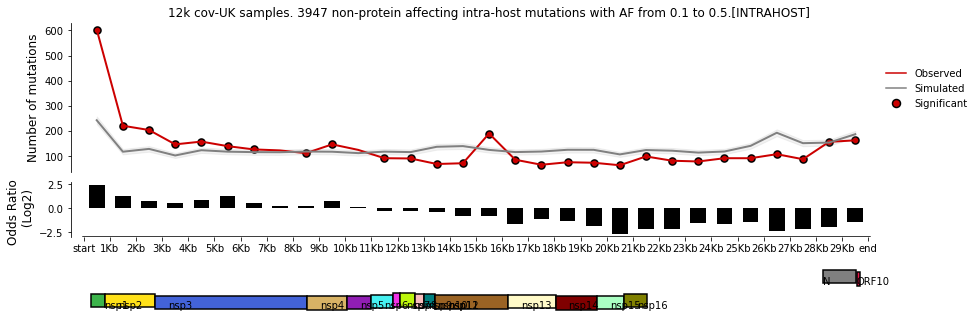

In [23]:
fig, ax = plt.subplots(figsize=(15, 5.5))
gs = gridspec.GridSpec(figure=fig, ncols=1, nrows=5,  height_ratios=[22, 8, 4, 2, 2])
gs.update(hspace=0.2, wspace=0.00)
ax0 = plt.subplot(gs[0]) # expected vs observed
ax1 = plt.subplot(gs[1]) # odds ratio
ax_ = plt.subplot(gs[2], sharex=ax0) # empy
ax2 = plt.subplot(gs[3], sharex=ax0) # genes-draw
ax3 = plt.subplot(gs[4], sharex=ax0) # genes-draw

x=dfintra01_05["id_chunk"].values
y1=dfintra01_05["n_observed"].values
y2=dfintra01_05["mean_simulated"].values
df_sig = dfintra01_05[dfintra002_005["pvalue"]<0.01]
# Observed
ax0.plot(y1,color="#cc0000",lw=2)
x_sig = df_sig["id_chunk"].values
y_sig = df_sig["n_observed"].values
ax0.scatter(x=x_sig,y=y_sig,color="#cc0000",s=50,lw=1.5,edgecolor="black")
ax0.set_ylabel("Number of mutations",fontsize=12)
# Simulated
ax0.plot(y2,color="grey",lw=2.)
# Confidence internals
y_low =[y2[i] - v for i,v in enumerate(dfintra01_05["stdev"].values)]
y_high =[y2[i] + v for i,v in enumerate(dfintra01_05["stdev"].values)]
ax0.fill_between(x,y_low,y_high,color="grey",alpha=0.1)
# barplots oddsratio
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_ylabel("Odds Ratio \n (Log2)",fontsize=12)
ax1.bar(x=x,height=dfintra01_05["log_odds_ratio"].values,color="black",width=0.6)

j=0
for i,r in df_annotations_total.sort_values("start").iterrows():
    rect = patches.Rectangle(xy=(r["start"]/1000-.5,ax2.get_ylim()[1]+random.uniform(-0.1,0.1)),width=(r["end"]-r["start"]+1)/1000,height=1,linewidth=1.5,facecolor=colors[j], clip_on=False, edgecolor="black")
    ax2.add_patch(rect)
    ax2.annotate(xy=(r["start"]/1000-.5,ax2.get_ylim()[1]),s=r["gene"])
    j+=1
    

for i,r in df_annotations[df_annotations["gene"].str.contains("nsp")].iterrows():
    rect = patches.Rectangle(xy=(r["start"]/1000-0.5,ax2.get_ylim()[1]+random.uniform(-0.1,0.1)),width=(r["end"]-r["start"]+1)/1000,height=1,linewidth=1.5,facecolor=colors[j], clip_on=False, edgecolor="black")
    ax3.add_patch(rect)
    ax3.annotate(xy=(r["start"]/1000,ax2.get_ylim()[1]),s=r["gene"])
    j+=1
    
_=ax1.set_xticks([v-0.5 for v in x]+[x[-1]+0.5])
_=ax1.set_xticklabels(["start"]+[str(v)+"Kb" for v in x[1:]]+["end"])
max_odd = np.nanmax(dfintra01_05["odds_ratio"].values) + 0.1
#ax1.set_ylim(-max_odd,max_odd)
ax2.set_xlabel("chunk number")
ax2.set_ylabel("number of mutations")
legend_elements = [Line2D([0], [0],  color='#cc0000', label='Observed',
                          markerfacecolor="#cc0000", markersize=10),
                   Line2D([0], [0],  color='grey', label='Simulated',
                          markerfacecolor='grey', markersize=10),
                  Line2D([0], [0],  color='white', label='Significant', markeredgewidth=1.5, markeredgecolor="black",
                          markerfacecolor='#cc0000', markersize=8, marker="o")]

# Create the figure
ax0.legend(handles=legend_elements, loc=(0.97,0.4),frameon=False)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

ax2.axis('off')
ax_.axis('off')
ax3.axis('off')
ax1.set_xlim(-1,31)
ax1.axhline(ax1.get_ylim()[0],xmin=0.015,xmax=0.955,lw=1.5,color="black")
ax2.set_xlim(-1,31)
ax3.set_xlim(-1,31)
ax0.set_xlim(-1,31)
ax0.set_xticks([])
ax0.set_title("Fig 15. 12k cov-UK samples. 3947 non-protein affecting intra-host mutations with AF from 0.1 to 0.5.[INTRAHOST]")
plt.savefig("./img/mutrate_intra0105.png")
plt.show()
